In [1]:
import random
import warnings
from dataclasses import replace

from tqdm import tqdm

from scripts.helpers import run_experiment
from scripts.plot import *
from scripts.propensity import get_propensity_scores
from variables.configs import final_configs
from variables.labels import *
from variables.variables import *

warnings.filterwarnings("ignore")
random.seed(42)

### Re-Generate Results with Selected Parameters and save tables

In [ ]:
# Extracts config from configs file and re-generates results with selected config for each variable
# Dataframes with ATE and ASMD are saved, plots are generated

REGENERATE_RESULTS = False

ps_dataframes = {}
if REGENERATE_RESULTS:
    feature_values = {}
    for exposure, config in tqdm(EXPOSURES.items()):
        params = final_configs[exposure]
        cfg = replace(
            BASE_CONFIG,
            clip=params['clip'],
            q=params['q'],
            method=config['method'],
            limit=config['cutoff'],
        )
        title = exposure.split('_target_day')[0]
        df, kwargs, X, shap_values = get_propensity_scores(
            exposure=exposure,
            config=cfg.__dict__,
            variables=variable_config,
            file=DATAFRAME_PATH,
        )
        ps_dataframes[title] = df
        
        current_flag = run_experiment(
            config=cfg.__dict__,
            variable_config=variable_config,
            df=df,
            kwargs=kwargs,
            X=X,
            shap_values=shap_values,
            save_results=True,
            log_experiment=False,
        )
        
    treatment_distributions = summarize_ps_dataframes_6cols(ps_dataframes, diet_definitions)
    treatment_distributions.to_csv(f"{paper_tables_folder}/treatment_distributions.csv")    
    feature_values = {}
    for title, df in ps_dataframes.items():
        exposure = f"{title}_target_day"
        feature_values[title] = {
            'treated' : list(df[df['treated'] == 1][exposure]),
            'control' : list(df[df['treated'] == 0][exposure]),
        }
    fig, axes = plot_test_control_distributions(feature_values, rdis=rdis, labels=diet_short_names_mapping)
    plt.show()

### Extraction

In [ ]:
import os

import pandas as pd
from statsmodels.stats.multitest import multipletests


def load_dataframes(
    folder_path=df_folder_path,
    type='results',
):
    dfs = {}
    for filename in os.listdir(folder_path):
        file_path = os.path.join(folder_path, filename)
        if filename.lower().endswith(".csv"):
            if '_ate' in filename.lower():
                if type == 'results':
                    df_name = filename.replace(".csv", "").replace("_ate", "")
                    df = pd.read_csv(file_path).set_index('outcome').loc[variable_config['sleep_targets']]
                    df['p_value_boot_abs_uncorrected'] = df['p_value_boot_abs']
                    df['p_value_boot_abs'] = multipletests(
                        list(df['p_value_boot_abs']),
                        alpha=0.05,
                        method="fdr_bh",
                        maxiter=1,
                        is_sorted=False,
                        returnsorted=False,
                    )[1]
                    df['is_significant_abs'] = [bool(p <= 0.05) for p in df['p_value_boot_abs']]
                    dfs[df_name] = df
                elif type == 'quality':
                    df_name = filename.replace(".csv", "").replace("_ate", "")
                    dfs[df_name] = pd.read_csv(file_path).set_index('outcome')
            elif type == 'asmd':
                df_name = filename.replace(".csv", "").replace("_asmd", "")
                temp = pd.read_csv(file_path).dropna()
                temp = temp.rename(columns={'feature': 'outcome'})
                dfs[df_name] = temp.set_index('outcome').dropna()
    return dfs

results = load_dataframes()
control = load_dataframes(type='quality')
asmd = load_dataframes(type='asmd')

print(f"Loaded {len(results)} dataframes")

Loaded 27 dataframes


### Quality Report

In [5]:
summary = summarize_runs(
    control,
    asmd,
    variable_config,
    outcome_col="outcome",
    labels=diet_short_names_mapping,
)

summary.to_csv(f"{paper_tables_folder}/quality_report.csv")
summary.style.bar(color="#ededed")

,% confounders with ASMD<0.1,% direct confounders with ASMD<0.05,% structural confounders with ASMD<0.05,% negative targets significant,max ASMD (confounders),mean ASMD (confounders)
dietary exposure,,,,,,
caffeine_late_mg,100.000000,100.000000,100.000000,0.000000,0.037654,0.020031
Last-meal–to-bedtime interval (h),100.000000,100.000000,100.000000,0.000000,0.044509,0.020953
Animal-based foods (% of daily energy),100.000000,100.000000,100.000000,0.000000,0.045215,0.026620
Zinc (mg),100.000000,100.000000,100.000000,0.000000,0.045395,0.022124
Meat and poultry (% of daily energy),100.000000,100.000000,100.000000,0.000000,0.045769,0.015638
Processed foods (% of daily energy),100.000000,100.000000,100.000000,0.000000,0.045805,0.016464
Dairy (% of daily energy),100.000000,100.000000,100.000000,0.000000,0.046258,0.024641
Vitamin D (mcg),100.000000,100.000000,100.000000,0.000000,0.046415,0.017298
Dinner energy (%),100.000000,100.000000,100.000000,0.000000,0.046482,0.016697


### Figure 2 (heatmap)


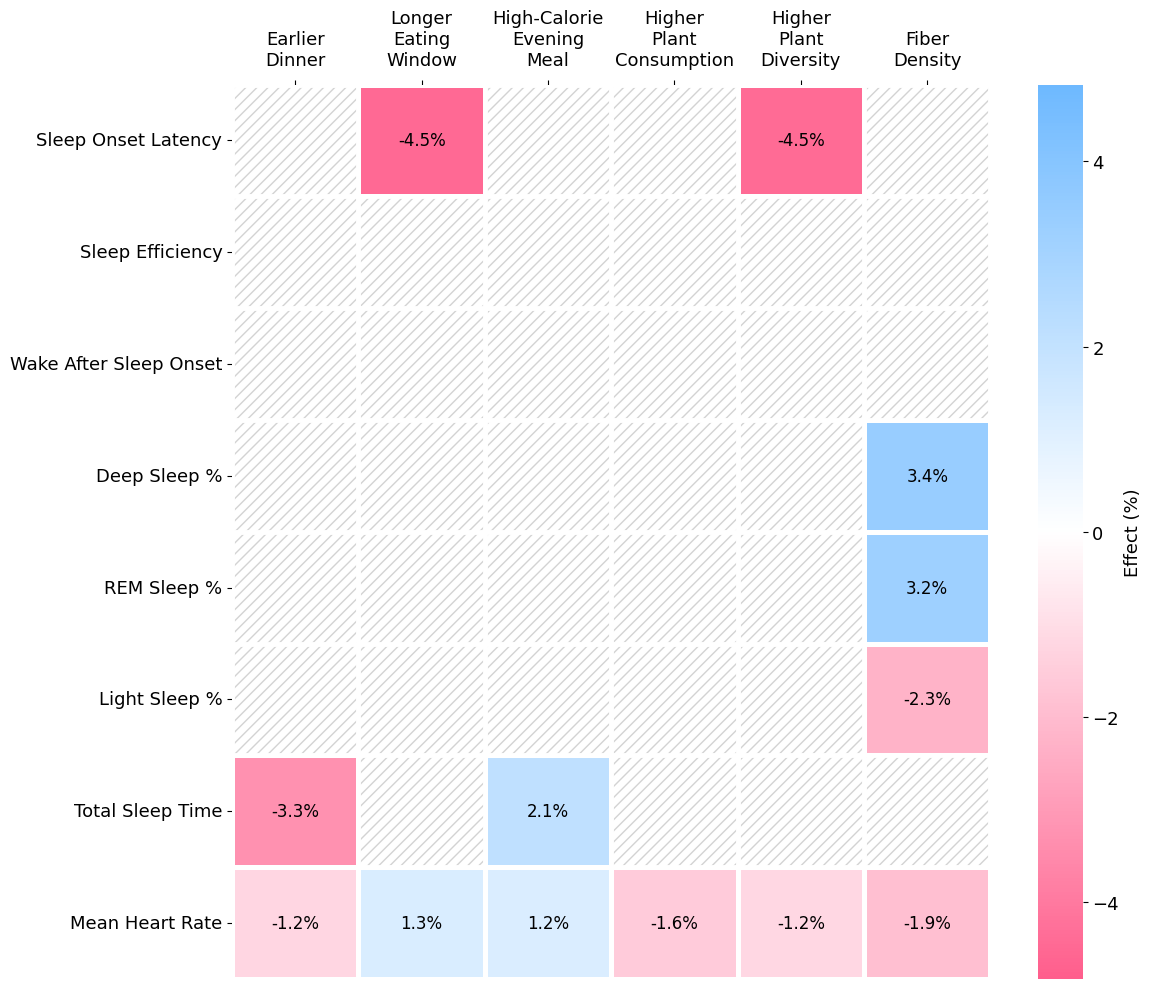

In [6]:
results_tmp = {k : v for k, v in results.items() if results[k]['is_significant_abs'].max() == True}
heatmap_effects_generic(
    list(results_tmp.values()),
    list(results_tmp.keys()),
    figsize=(12, 10),
    labels_dict=labels_dict,
    x_labels=diet_full_names_mapping,
)

### Main figures

In [7]:
meal_timing_features = ['night_calories_pct', 'hours_to_sleep', 'eating_window_h']
plant_based_features = ['fiber_density_energy', 'unique_plant_based_foods_count', 'plant_based_whole_foods_ratio']

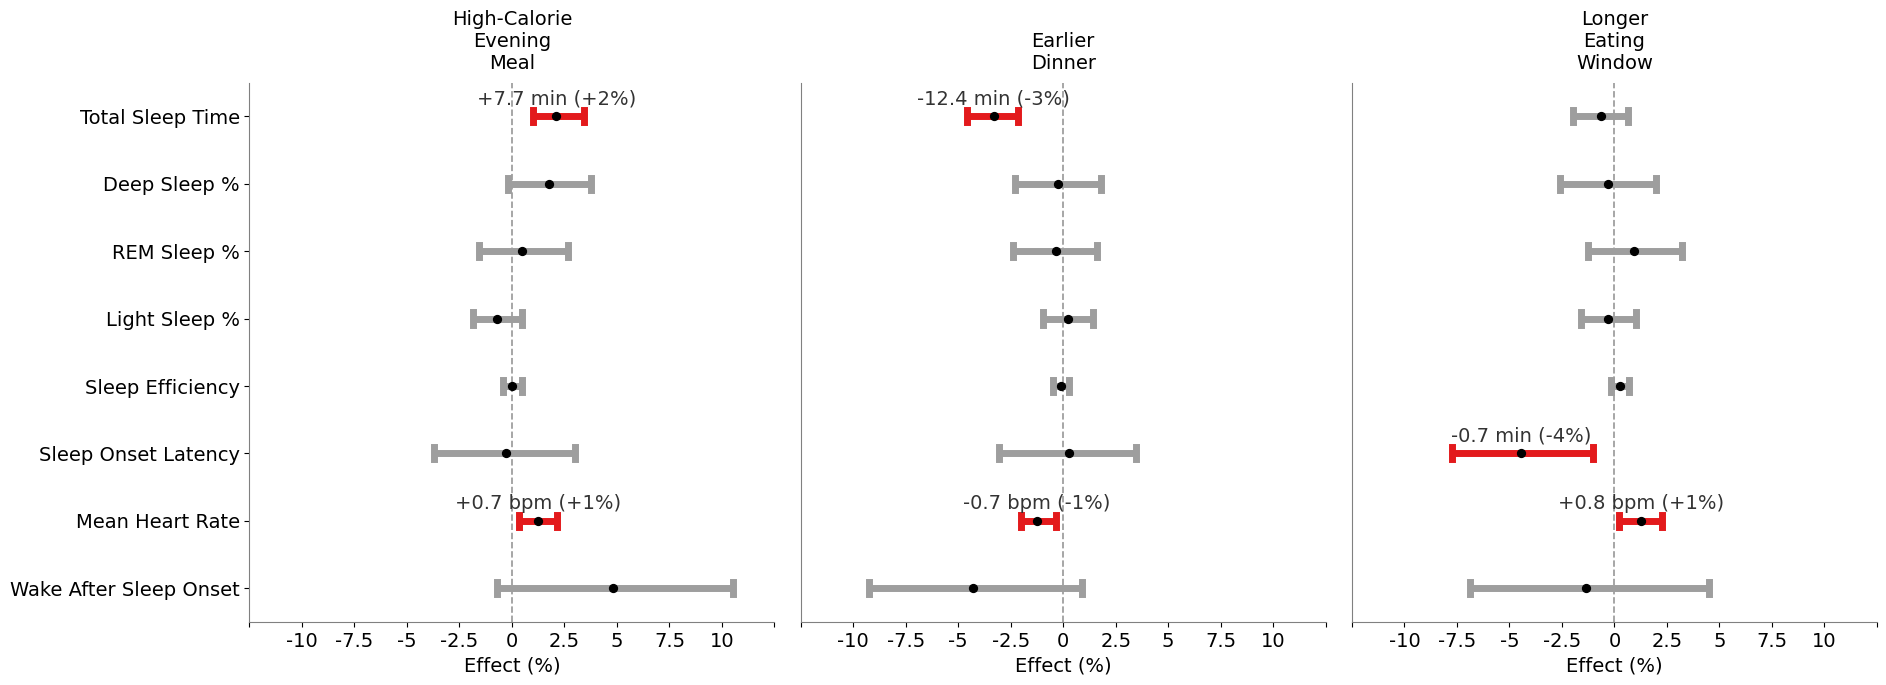

In [8]:
to_plot = meal_timing_features

results_tmp = {k : v for k, v in results.items() if k in to_plot}
results_renamed = {diet_full_names_mapping[k] : v for k, v in results_tmp.items()}

fig, ax = plot_outcome_effects_panels_significant(
    
    dfs=results_renamed.values(),
    df_labels=results_renamed.keys(),
    labels_dict=labels_dict,
    annotation_dict=annotation_dict,
    
    figsize_per_panel=(7, 7),
    x_label = "Effect (%)",
    ci_line_width = 5,
    p_fontsize = 14,
    panels_per_row= 4,
)
plt.show()

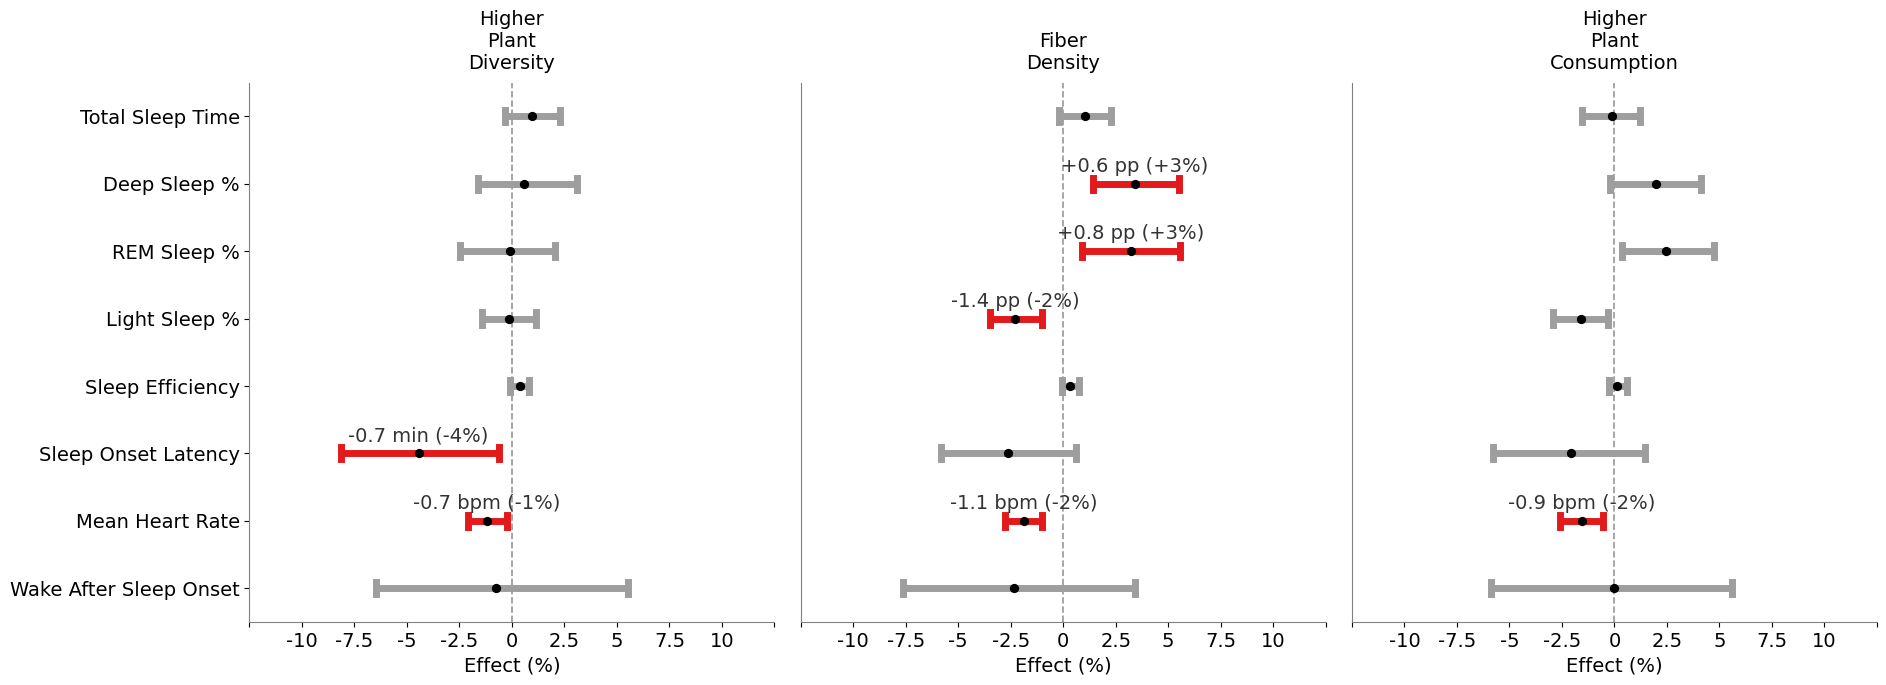

In [9]:
to_plot = plant_based_features

results_tmp = {k : v for k, v in results.items() if k in to_plot}
results_renamed = {diet_full_names_mapping[k] : v for k, v in results_tmp.items()}

fig, ax = plot_outcome_effects_panels_significant(
    
    dfs=results_renamed.values(),
    df_labels=results_renamed.keys(),
    labels_dict=labels_dict,
    annotation_dict=annotation_dict,
    
    figsize_per_panel=(7, 7),
    x_label = "Effect (%)",
    ci_line_width = 5,
    p_fontsize = 14,
    panels_per_row= 4,
)
plt.show()

### Same plot

In [ ]:
vit_plants = [
    'magnesium_mg',
    'vitamin_c',
    'folate',
    'vitamin_e',
]

vit_aminal = [
    'vitamin_d_ug',
    'vitamin_b6_mg', 
    'vitamin_b12_ug', 
]

vit_mixed = [
    'omega3_total_g',
    'zinc_mg', 
    'calcium_mg', 
]

macros = [
    'prot_pct',
    'fat_pct',
    'carb_pct',
]

composition_processed = [
    'processed_categories_ratio', 
    'meat_and_poultry_energy_ratio', 
    'animal_based_whole_foods_ratio',
    'sat_fat_g', 
]

composition_whole = [
    'furits_and_veggies_energy_ratio', 
    'whole_food_categories_ratio', 
    'whole_dairy_categories_ratio',
]

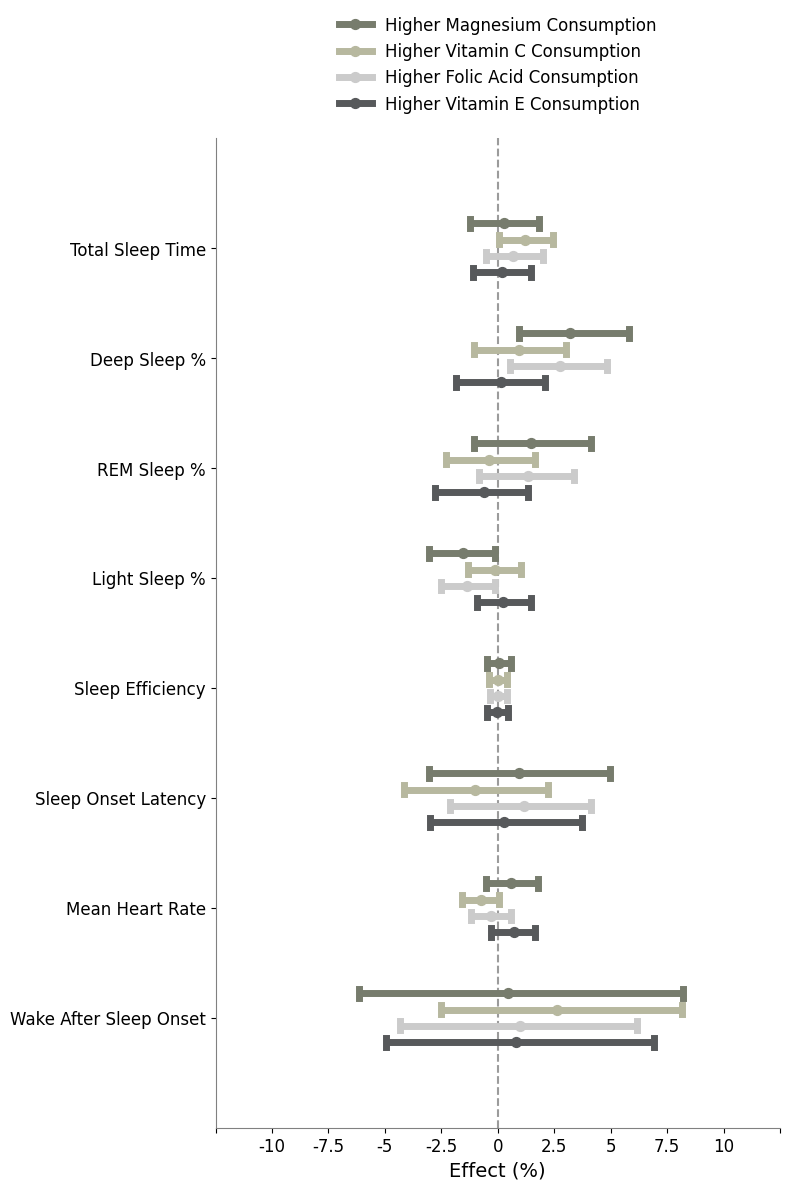

In [ ]:
fig, ax = plot_outcome_effects_panels(
    results=results,
    to_plot=vit_plants,
    exposure_labels=diet_full_names_mapping,
    labels_dict=labels_dict,
    figsize_per_panel=(8, 12),
    x_label="Effect (%)",
    ci_line_width=5,
    p_fontsize=11,
)
plt.show()

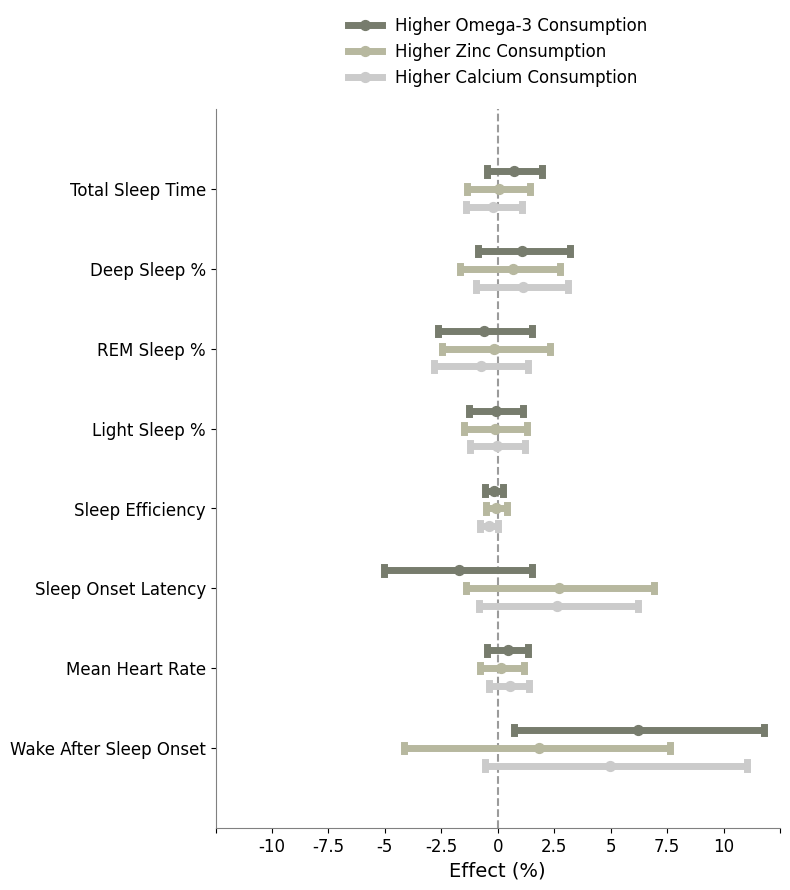

In [ ]:
fig, ax = plot_outcome_effects_panels(
    results=results,
    to_plot=vit_mixed,
    exposure_labels=diet_full_names_mapping,
    labels_dict=labels_dict,
    figsize_per_panel=(8, 9),
    x_label="Effect (%)",
    ci_line_width=5,
    p_fontsize=11,
)
plt.show()

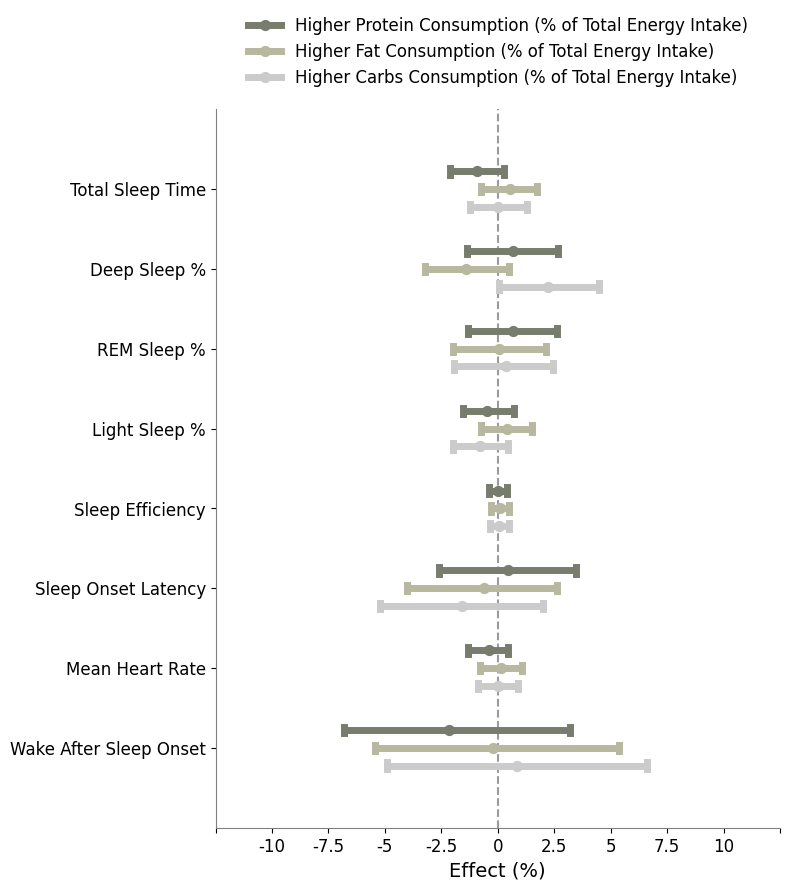

In [ ]:
fig, ax = plot_outcome_effects_panels(
    results=results,
    to_plot=macros,
    exposure_labels=diet_full_names_mapping,
    labels_dict=labels_dict,
    figsize_per_panel=(8, 9),
    x_label="Effect (%)",
    ci_line_width=5,
    p_fontsize=11,
)
plt.show()

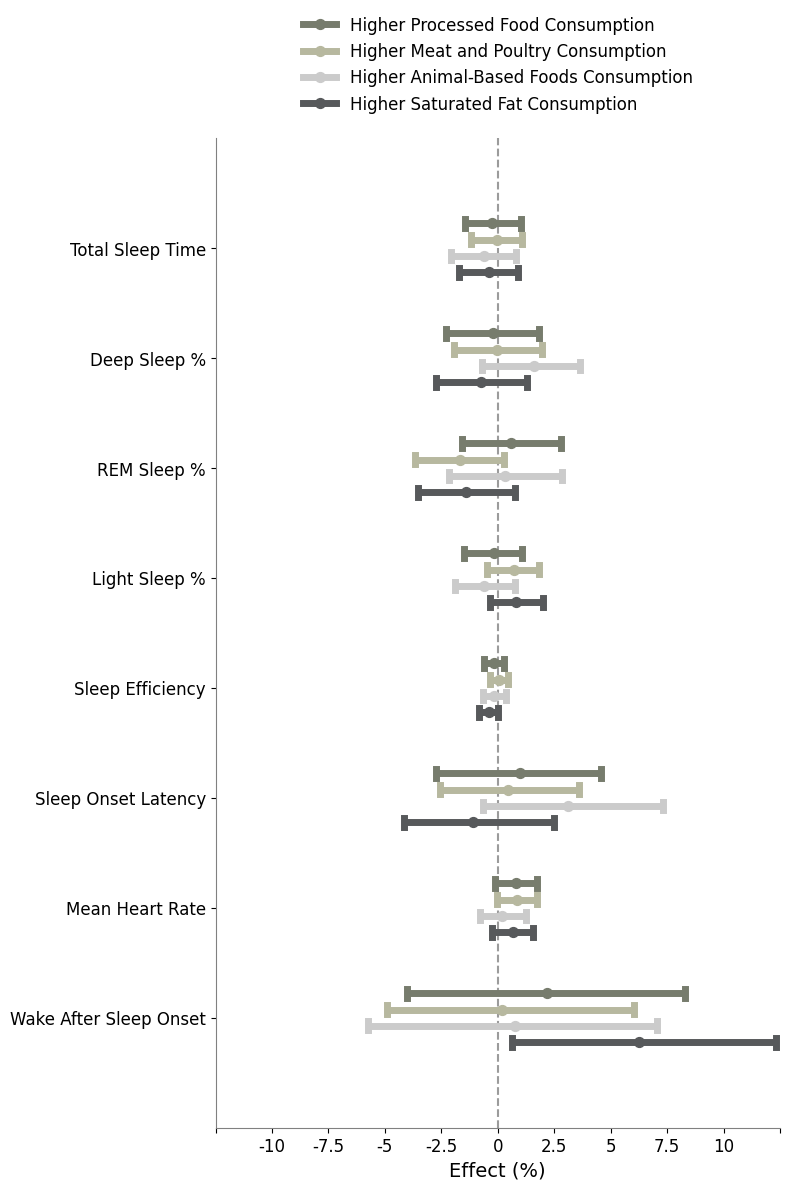

In [ ]:
fig, ax = plot_outcome_effects_panels(
    results=results,
    to_plot=composition_processed,
    exposure_labels=diet_full_names_mapping,
    labels_dict=labels_dict,
    figsize_per_panel=(8, 12),
    x_label="Effect (%)",
    ci_line_width=5,
    p_fontsize=11,
)
plt.show()

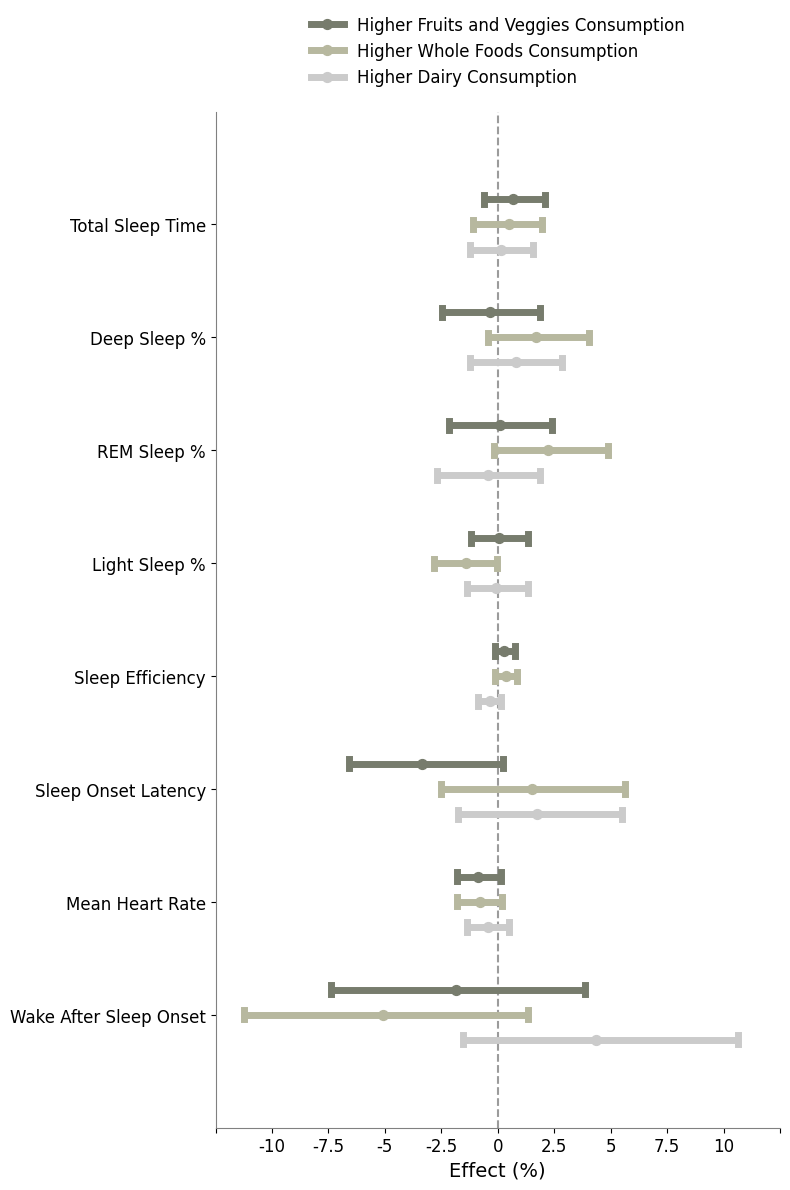

In [ ]:
fig, ax = plot_outcome_effects_panels(
    results=results,
    to_plot=composition_whole,
    exposure_labels=diet_full_names_mapping,
    labels_dict=labels_dict,
    figsize_per_panel=(8, 12),
    x_label="Effect (%)",
    ci_line_width=5,
    p_fontsize=11,
)
plt.show()